In [1]:
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import xgboost as xgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='ggplot')
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sampleSubmission.csv')
test_id = test['id']

In [3]:
print(train.shape)
train.head()

(32769, 10)


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
print(test.shape)
test.head()

(58921, 10)


,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [5]:
sample.head()

,Id,Action
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# Exploration

ACTION: ACTION is 1 if the resource was approved, 0 if the resource was not.

RESOURCE: An ID for each resource.

MGR_ID: The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time.

ROLE_ROLLUP_1: Company role grouping category id 1 (e.g. US Engineering).

ROLE_ROLLUP_2: Company role grouping category id 2 (e.g. US Retail).

ROLE_DEPTNAME: Company role department description (e.g. Retail).

ROLE_TITLE: Company role business title description (e.g. Senior Engineering Retail Manager).

ROLE_FAMILY_DESC: Company role family extended description (e.g. Retail Manager, Software Engineering).

ROLE_FAMILY: Company role family description (e.g. Retail Manager).

ROLE_CODE: Company role code; this code is unique to each role (e.g. Manager).

In [6]:
print(train.shape)
print(train.isnull().sum())
train.info()

(32769, 10)
ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [7]:
print(test.shape)
print(test.isnull().sum())
test.info()

(58921, 10)
id                  0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                58921 non-null  int64
 1   RESOURCE          58921 non-null  int64
 2   MGR_ID            58921 non-null  int64
 3   ROLE_ROLLUP_1     58921 non-null  int64
 4   ROLE_ROLLUP_2     58921 non-null  int64
 5   ROLE_DEPTNAME     58921 non-null  int64
 6   ROLE_TITLE        58921 non-null  int64
 7   ROLE_FAMILY_DESC  58921 non-null  int64
 8   ROLE_FAMILY       58921 non-null  int64
 9   ROLE_CODE         58921 non-null  int64
dtypes: int64(10)
memory usage: 4.5 MB


## No null values, let's check outliers, skewness

<AxesSubplot:xlabel='ACTION', ylabel='Density'>

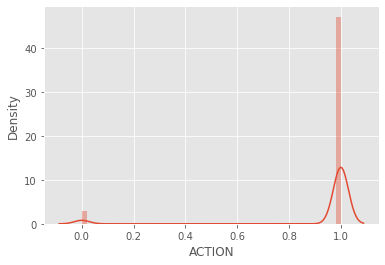

In [8]:
sns.distplot(train['ACTION'])

----------Box Plots for detecting outliers---------


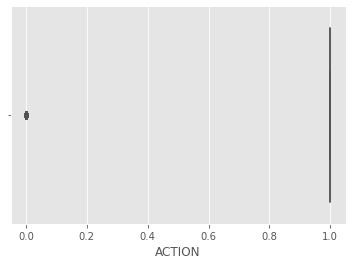

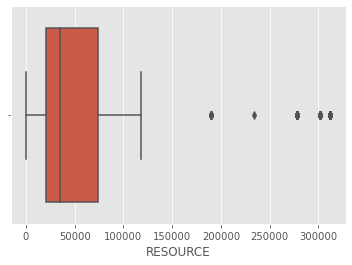

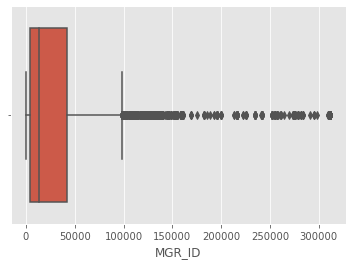

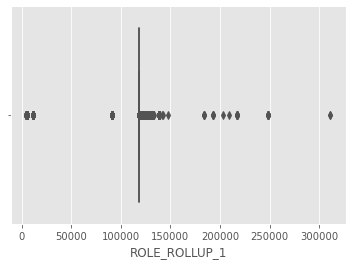

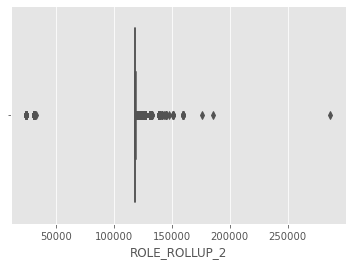

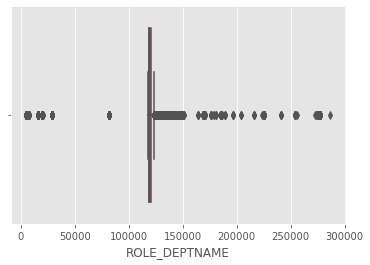

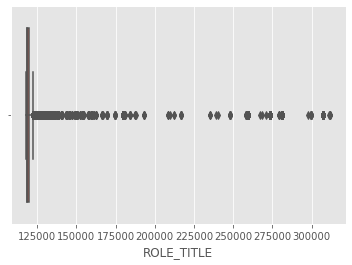

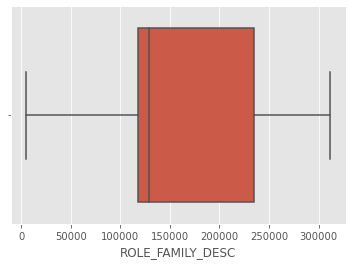

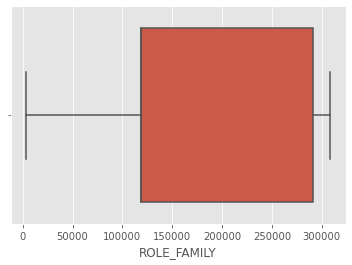

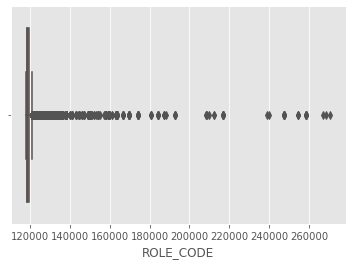

In [9]:
print("----------Box Plots for detecting outliers---------")
cols = train.columns
for i in cols:
    plt.figure()
    sns.boxplot(train[i])

#### Check the test set to make sure we don't delete important data

<AxesSubplot:xlabel='RESOURCE'>

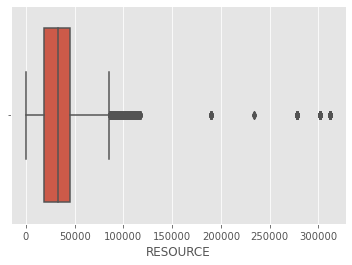

In [10]:
# Resource
sns.boxplot(test['RESOURCE'])

<AxesSubplot:xlabel='ROLE_ROLLUP_1'>

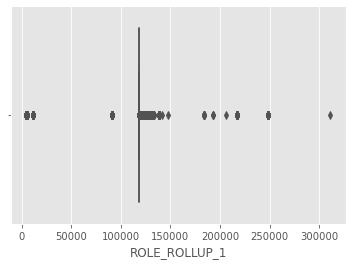

In [11]:
# Role Rollup 1
sns.boxplot(test['ROLE_ROLLUP_1'])

<AxesSubplot:xlabel='ROLE_ROLLUP_2'>

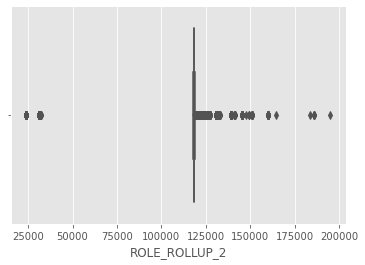

In [12]:
# Role Rollup 2
sns.boxplot(test['ROLE_ROLLUP_2'])

<AxesSubplot:xlabel='ROLE_DEPTNAME'>

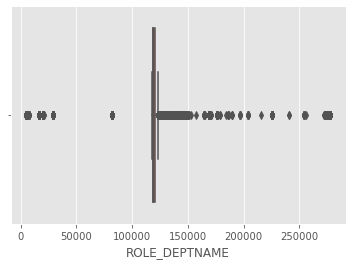

In [13]:
# Role Detpname
sns.boxplot(test['ROLE_DEPTNAME'])

<AxesSubplot:xlabel='ROLE_CODE'>

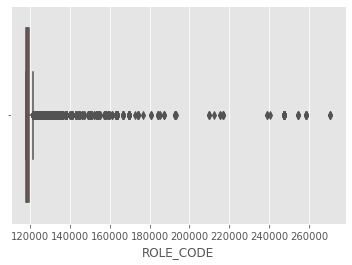

In [14]:
# Role Code
sns.boxplot(test['ROLE_CODE'])

- I guess it's gonna be better if we do nothing with ('resource', 'role rollup 1', 'role_detpname', 'role_code') columns
- We handle the rest of the outliers

In [15]:
# resource_outliers = train[train['RESOURCE'] > 150000]
# role_rollup_1_outliers1 = train[train['ROLE_ROLLUP_1'] > 150000]  
# role_rollup_1_outliers2 = train[train['ROLE_ROLLUP_1'] < 100000]
# role_rollup_1_outliers = pd.concat([role_rollup_1_outliers1, role_rollup_1_outliers2], axis=0)
role_rollup_2_outliers1 = train[train['ROLE_ROLLUP_2'] > 200000]
# role_rollup_2_outliers2 = train[train['ROLE_ROLLUP_2'] < 100000]
# role_rollup_2_outliers = pd.concat([role_rollup_2_outliers1, role_rollup_2_outliers2], axis=0)
# role_deptname_outliers = train[train['ROLE_DEPTNAME'] < 100000]
# role_code_outliers = train[train['ROLE_CODE'] > 200000]
# print("Rsource outliers:", len(resource_outliers))
# print("Role Rollup 1 outliers:", len(role_rollup_1_outliers))
print("Role Rollup 2 outliers:", len(role_rollup_2_outliers1))
# print("Role detname outliers:", len(role_deptname_outliers))
# print("Role code outliers:", len(role_code_outliers))

Role Rollup 2 outliers: 1


In [16]:
# print(train.shape)
# lst = [resource_outliers, role_rollup_1_outliers, role_rollup_2_outliers, role_deptname_outliers, role_code_outliers]
# for i in lst:
#     todrop = list(i.index)
#     try:
#         train.drop(todrop, axis=0, inplace=True)
#     except Exception as e:
#         print(len(i))
#         print(e)
#         continue
# print(train.shape)

In [17]:
print(train.shape)
todrop = list(role_rollup_2_outliers1.index)
train.drop(todrop, axis=0, inplace=True)
print(train.shape)

(32769, 10)
(32768, 10)


In [18]:
train.reset_index(drop=True)

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325
...,...,...,...,...,...,...,...,...,...,...
32763,1,23497,16971,117961,118300,119993,118321,240983,290919,118322
32764,1,25139,311198,91261,118026,122392,121143,173805,249618,121145
32765,1,34924,28805,117961,118327,120299,124922,152038,118612,124924
32766,1,80574,55643,118256,118257,117945,280788,280788,292795,119082


## Skewness 

In [19]:
train.skew()

ACTION              -3.787536
RESOURCE             2.806774
MGR_ID               3.360216
ROLE_ROLLUP_1       -6.457891
ROLE_ROLLUP_2      -16.622190
ROLE_DEPTNAME       -0.205352
ROLE_TITLE           4.952601
ROLE_FAMILY_DESC     0.993770
ROLE_FAMILY         -0.078013
ROLE_CODE           13.357147
dtype: float64

# EDA

In [20]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ACTION,32768.0,0.942139,0.233485,0.0,1.0,1.0,1.0,1.0
RESOURCE,32768.0,42922.758484,34173.771580,0.0,20299.0,35376.0,74187.5,312153.0
MGR_ID,32768.0,25989.506042,35928.442897,25.0,4566.0,13545.0,42034.0,311696.0
ROLE_ROLLUP_1,32768.0,116952.597015,10875.728116,4292.0,117961.0,117961.0,117961.0,311178.0
ROLE_ROLLUP_2,32768.0,118296.681274,4455.467035,23779.0,118102.0,118300.0,118386.0,185842.0
ROLE_DEPTNAME,32768.0,118907.656647,18938.917512,4674.0,118394.0,118921.0,120535.0,277693.0
ROLE_TITLE,32768.0,125916.397125,31036.907860,117879.0,118274.0,118568.0,120006.0,311867.0
ROLE_FAMILY_DESC,32768.0,170179.964874,69509.922935,4673.0,117906.0,128696.0,235280.0,311867.0
ROLE_FAMILY,32768.0,183700.136932,100488.195184,3130.0,118363.0,119006.0,290919.0,308574.0
ROLE_CODE,32768.0,119789.487549,5784.354440,117880.0,118232.0,118570.0,119348.0,270691.0


<AxesSubplot:>

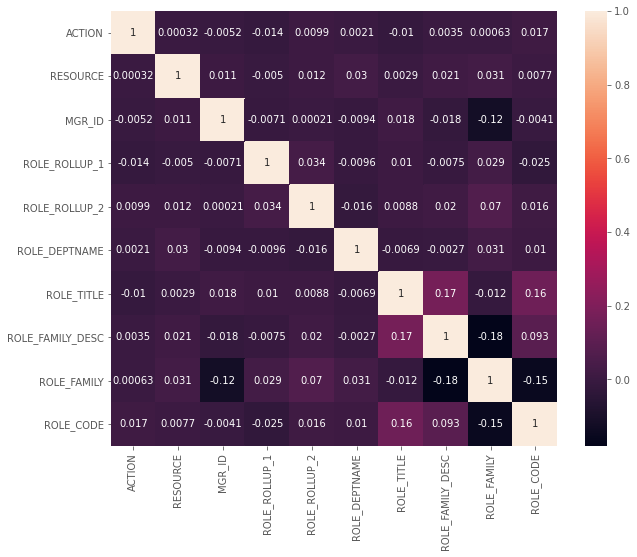

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), annot=True)

### Resource

In [22]:
train['RESOURCE'][:10]

0    39353
1    17183
2    36724
3    36135
4    42680
5    45333
6    25993
7    19666
8    31246
9    78766
Name: RESOURCE, dtype: int64

<Figure size 648x432 with 0 Axes>

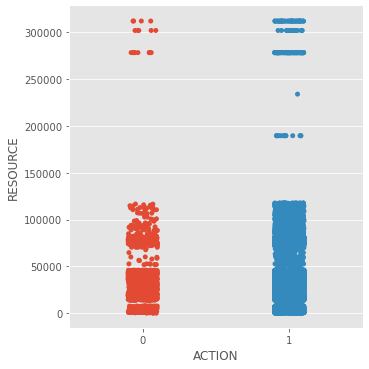

In [23]:
plt.figure(figsize=(9, 6))
sns.catplot('ACTION', 'RESOURCE', data=train)

### MGR_ID

In [24]:
train['MGR_ID'][:10]

0    85475
1     1540
2    14457
3     5396
4     5905
5    14561
6    17227
7     4209
8      783
9    56683
Name: MGR_ID, dtype: int64

<Figure size 648x432 with 0 Axes>

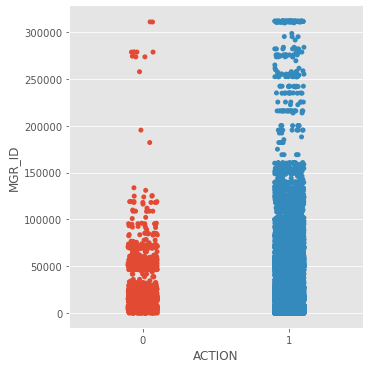

In [25]:
plt.figure(figsize=(9, 6))
sns.catplot('ACTION', 'MGR_ID', data=train)

We could generate a new feature here called 'is_MGR_ID_BiggerThan150000'

In [26]:
temp = pd.DataFrame(columns=['is_MGR_ID_BiggerThan150000'], dtype=np.float32)
train = pd.concat([train, temp], axis=1)
for i in range(train.shape[0]):
    try:
        if train['MGR_ID'][i] > 150000:
            train['is_MGR_ID_BiggerThan150000'][i] = 1
        else:
            train['is_MGR_ID_BiggerThan150000'][i] = 0
    except Exception:
        train['is_MGR_ID_BiggerThan150000'][i] = 0
        pass
    
    
temp = pd.DataFrame(columns=['is_MGR_ID_BiggerThan150000'], dtype=np.float32)
test = pd.concat([test, temp], axis=1)
for i in range(test.shape[0]):
    try:
        if test['MGR_ID'][i] > 150000:
            test['is_MGR_ID_BiggerThan150000'][i] = 1
        else:
            test['is_MGR_ID_BiggerThan150000'][i] = 0
    except Exception:
        test['is_MGR_ID_BiggerThan150000'][i] = 0
        pass

### ROLE_ROLLUP_1

In [27]:
train['ROLE_ROLLUP_1'][:10]

0    117961
1    117961
2    118219
3    117961
4    117929
5    117951
6    117961
7    117961
8    117961
9    118079
Name: ROLE_ROLLUP_1, dtype: int64

<Figure size 864x864 with 0 Axes>

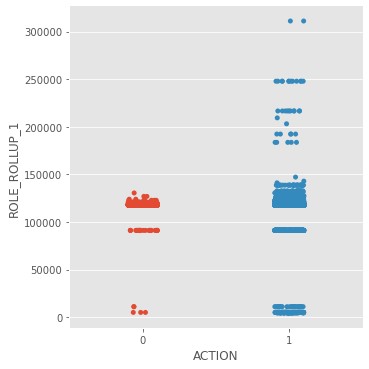

In [28]:
plt.figure(figsize=(12, 12))
sns.catplot('ACTION', 'ROLE_ROLLUP_1', data=train)

We could generate a new feature here called 'is_ROLE_ROLLUP_1_BiggerThan150000'

In [29]:
temp = pd.DataFrame(columns=['is_ROLE_ROLLUP_1_BiggerThan150000'], dtype=np.float32)
train = pd.concat([train, temp], axis=1)
for i in range(train.shape[0]):
    try:
        if train['ROLE_ROLLUP_1'][i] > 150000:
            train['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 1
        else:
            train['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 0
    except Exception:
        train['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 0
        pass
    
temp = pd.DataFrame(columns=['is_ROLE_ROLLUP_1_BiggerThan150000'], dtype=np.float32)
test = pd.concat([test, temp], axis=1)
for i in range(test.shape[0]):
    try:
        if test['ROLE_ROLLUP_1'][i] > 150000:
            test['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 1
        else:
            test['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 0
    except Exception:
        test['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 0
        pass

### ROLE_ROLLUP_2

In [30]:
train['ROLE_ROLLUP_2'][:10]

0    118300
1    118343
2    118220
3    118343
4    117930
5    117952
6    118343
7    117969
8    118413
9    118080
Name: ROLE_ROLLUP_2, dtype: int64

In [31]:
train['ROLE_ROLLUP_2'].value_counts()

118300    4424
118343    3945
118327    2641
118225    2547
118386    1796
          ... 
118775       1
120355       1
176316       1
141222       1
147237       1
Name: ROLE_ROLLUP_2, Length: 176, dtype: int64

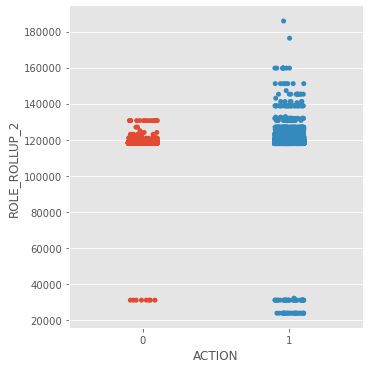

In [32]:
sns.catplot('ACTION', 'ROLE_ROLLUP_2', data=train)

We could generate a new feature here called 'is_ROLE_ROLLUP_2_BiggerThan140000'

In [33]:
temp = pd.DataFrame(columns=['is_ROLE_ROLLUP_2_BiggerThan140000'], dtype=np.float32)
train = pd.concat([train, temp], axis=1)
for i in range(train.shape[0]):
    try:
        if train['ROLE_ROLLUP_2'][i] > 140000:
            train['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 1
        else:
            train['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 0
    except Exception:
        train['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 0
        pass
    
temp = pd.DataFrame(columns=['is_ROLE_ROLLUP_2_BiggerThan140000'], dtype=np.float32)
test = pd.concat([test, temp], axis=1)
for i in range(test.shape[0]):
    try:
        if test['ROLE_ROLLUP_2'][i] > 140000:
            test['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 1
        else:
            test['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 0
    except Exception:
        test['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 0
        pass

### ROLE_DEPTNAME

In [34]:
train['ROLE_DEPTNAME'][:10]

0    123472
1    123125
2    117884
3    119993
4    119569
5    118008
6    123476
7    118910
8    120584
9    117878
Name: ROLE_DEPTNAME, dtype: int64

In [35]:
train['ROLE_DEPTNAME'].value_counts()

117878    1135
117941     763
117945     659
118514     601
117920     597
          ... 
134848       1
139001       1
122963       1
121030       1
123675       1
Name: ROLE_DEPTNAME, Length: 448, dtype: int64

<Figure size 648x432 with 0 Axes>

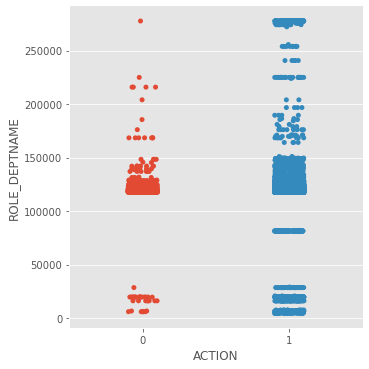

In [36]:
plt.figure(figsize=(9, 6))
sns.catplot('ACTION', 'ROLE_DEPTNAME', data=train)

In [37]:
len(train[train['ROLE_DEPTNAME'] < 100000])

729

Not enough to generate some feature for it

### ROLE_TITLE

In [38]:
train['ROLE_TITLE'][:10]

0    117905
1    118536
2    117879
3    118321
4    119323
5    118568
6    118980
7    126820
8    128230
9    117879
Name: ROLE_TITLE, dtype: int64

In [39]:
train['ROLE_TITLE'].value_counts()

118321    4649
117905    3582
118784    1772
117879    1256
118568    1043
          ... 
122188       1
157799       1
157359       1
166800       1
130633       1
Name: ROLE_TITLE, Length: 343, dtype: int64

<Figure size 648x432 with 0 Axes>

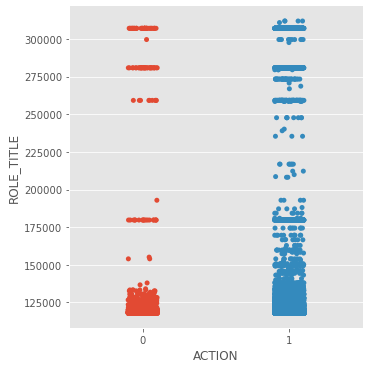

In [40]:
plt.figure(figsize=(9, 6))
sns.catplot('ACTION', 'ROLE_TITLE', data=train)

### ROLE_FAMILY_DESC

In [41]:
train['ROLE_FAMILY_DESC'][:10]

0    117906
1    118536
2    267952
3    240983
4    123932
5    118568
6    301534
7    269034
8    302830
9    304519
Name: ROLE_FAMILY_DESC, dtype: int64

In [42]:
train['ROLE_FAMILY_DESC'].value_counts()

117906    6895
240983    1244
117913     670
279443     665
117886     530
          ... 
151040       1
153123       1
251257       1
306550       1
247799       1
Name: ROLE_FAMILY_DESC, Length: 2358, dtype: int64

<Figure size 648x504 with 0 Axes>

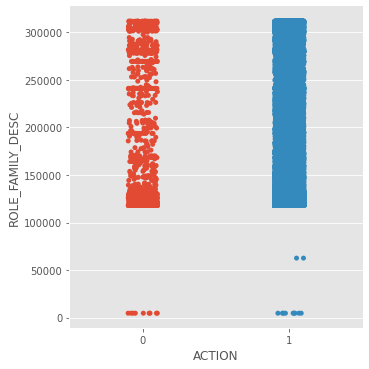

In [43]:
plt.figure(figsize=(9, 7))
sns.catplot('ACTION', 'ROLE_FAMILY_DESC', data=train)

### ROLE_FAMILY

In [44]:
train['ROLE_FAMILY'][:10]

0    290919
1    308574
2     19721
3    290919
4     19793
5     19721
6    118295
7    118638
8      4673
9     19721
Name: ROLE_FAMILY, dtype: int64

In [45]:
train['ROLE_FAMILY'].value_counts()

290919    10979
118424     2690
19721      2636
117887     2400
292795     1318
          ...  
127957        3
136398        3
132725        2
161100        2
149353        2
Name: ROLE_FAMILY, Length: 67, dtype: int64

<Figure size 648x432 with 0 Axes>

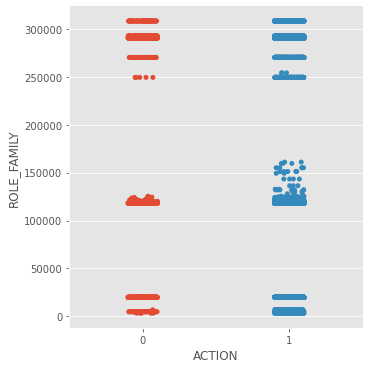

In [46]:
plt.figure(figsize=(9, 6))
sns.catplot('ACTION', 'ROLE_FAMILY', data=train)

### ROLE_CODE

In [47]:
train['ROLE_CODE'][:10]

0    117908
1    118539
2    117880
3    118322
4    119325
5    118570
6    118982
7    126822
8    128231
9    117880
Name: ROLE_CODE, dtype: int64

In [48]:
train['ROLE_CODE'].value_counts()

118322    4649
117908    3582
118786    1772
117880    1256
118570    1043
          ... 
157361       1
119817       1
208567       1
130365       1
123657       1
Name: ROLE_CODE, Length: 343, dtype: int64

<Figure size 648x432 with 0 Axes>

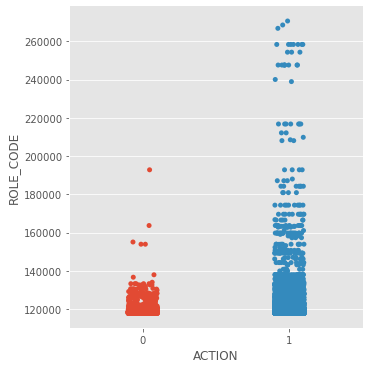

In [49]:
plt.figure(figsize=(9, 6))
sns.catplot('ACTION', 'ROLE_CODE', data=train)

We could generate a new feature here called 'is_ROLE_CODE_BiggerThan200000'

In [50]:
temp = pd.DataFrame(columns=['is_ROLE_CODE_BiggerThan200000'], dtype=np.float32)
train = pd.concat([train, temp], axis=1)
for i in range(train.shape[0]):
    try:
        if train['ROLE_CODE'][i] > 140000:
            train['is_ROLE_CODE_BiggerThan200000'][i] = 1
        else:
            train['is_ROLE_CODE_BiggerThan200000'][i] = 0
    except Exception:
        train['is_ROLE_CODE_BiggerThan200000'][i] = 0
        pass
    
temp = pd.DataFrame(columns=['is_ROLE_CODE_BiggerThan200000'], dtype=np.float32)
test = pd.concat([test, temp], axis=1)
for i in range(test.shape[0]):
    try:
        if test['ROLE_CODE'][i] > 140000:
            test['is_ROLE_CODE_BiggerThan200000'][i] = 1
        else:
            test['is_ROLE_CODE_BiggerThan200000'][i] = 0
    except Exception:
        test['is_ROLE_CODE_BiggerThan200000'][i] = 0
        pass

In [51]:
train['is_ROLE_CODE_BiggerThan200000'].value_counts()

0.0    32534
1.0      233
Name: is_ROLE_CODE_BiggerThan200000, dtype: int64

In [52]:
train.isnull().sum()

ACTION                               0
RESOURCE                             0
MGR_ID                               0
ROLE_ROLLUP_1                        0
ROLE_ROLLUP_2                        0
ROLE_DEPTNAME                        0
ROLE_TITLE                           0
ROLE_FAMILY_DESC                     0
ROLE_FAMILY                          0
ROLE_CODE                            0
is_MGR_ID_BiggerThan150000           1
is_ROLE_ROLLUP_1_BiggerThan150000    1
is_ROLE_ROLLUP_2_BiggerThan140000    1
is_ROLE_CODE_BiggerThan200000        1
dtype: int64

In [53]:
train[train['is_MGR_ID_BiggerThan150000'].isnull()]
train.drop(32768, axis=0, inplace=True)

# Modelling

In [59]:
y = train['ACTION']
train.drop('ACTION', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [60]:
train_means = train.mean()
train_stds = train.std()
train = (train - train_means) / train_stds

test_means = test.mean()
test_stds = test.std()
test = (test - test_means) / test_stds

In [61]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

In [62]:
# Logistic Regression
lr = LogisticRegression()
# Training
lr.fit(X_train, y_train)

# Predict training set
y_pred_lr_train = lr.predict(X_train)
# Metrics on training set
print("Accuracy on training set(Logistic Regression):", accuracy_score(y_pred_lr_train, y_train))
print("F1 score on training set(Logistic Regression):", f1_score(y_pred_lr_train, y_train))
fpr, tpr, thresholds = roc_curve(y_train, y_pred_lr_train, pos_label=1)
# print("Area under the ROC cure on training set:", auc(fpr, tpr))

# Predict Validation set
y_pred_lr_validation = lr.predict(X_test)
# Metrics on validation set
print("Accuracy on validation set(Logistic Regression):", accuracy_score(y_pred_lr_validation, y_test))
print("F1 score on validation set(Logistic Regression):", f1_score(y_pred_lr_validation, y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr_validation, pos_label=1)
# print("Area under the ROC cure on validation set:", auc(fpr, tpr))

Accuracy on training set(Logistic Regression): 0.941860908709419
F1 score on training set(Logistic Regression): 0.9700601155160897
Accuracy on validation set(Logistic Regression): 0.9432407689960329
F1 score on validation set(Logistic Regression): 0.9707914572864321


In [63]:
# Normalized
# Accuracy on training set(Logistic Regression): 0.942397192339971
# F1 score on training set(Logistic Regression): 0.9703444754310853
# Accuracy on validation set(Logistic Regression): 0.9411046689044859
# F1 score on validation set(Logistic Regression): 0.9696588586700206

# Normalized and generated features
# Accuracy on training set(Logistic Regression): 0.941860908709419
# F1 score on training set(Logistic Regression): 0.9700601155160897
# Accuracy on validation set(Logistic Regression): 0.9432407689960329
# F1 score on validation set(Logistic Regression): 0.9707914572864321

In [64]:
# Decision Tree
dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5)
# Train Decision tree model
dt.fit(X_train, y_train)

# Predict training set
y_pred_dt_train = dt.predict(X_train)
# Metrics on training set
print("Accuracy on training set(Decision Tree):", accuracy_score(y_pred_dt_train, y_train))
print("F1 score on training set(Decision Tree):", f1_score(y_pred_dt_train, y_train))
fpr, tpr, thresholds = roc_curve(y_train, y_pred_dt_train, pos_label=1)
# print("Area under the ROC cure on training set:", auc(fpr, tpr))

# Predict Validation set
y_pred_df_validation = dt.predict(X_test)
# Metrics on validation set
print("Accuracy on validation set(Decision Tree):", accuracy_score(y_pred_df_validation, y_test))
print("F1 score on validation set(Decision Tree):", f1_score(y_pred_df_validation, y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_df_validation, pos_label=1)
# print("Area under the ROC cure on validation set:", auc(fpr, tpr))

Accuracy on training set(Decision Tree): 0.943272422080647
F1 score on training set(Decision Tree): 0.9707369871101053
Accuracy on validation set(Decision Tree): 0.94278303326213
F1 score on validation set(Decision Tree): 0.9705211854413962


In [65]:
# Normalized
# Accuracy on training set(Decision Tree): 0.9433127336537728
# F1 score on training set(Decision Tree): 0.9707514860449553
# Accuracy on validation set(Decision Tree): 0.9404943545926152
# F1 score on validation set(Decision Tree): 0.9692961738308927

# Normalized and generated features
# Accuracy on training set(Decision Tree): 0.943272422080647
# F1 score on training set(Decision Tree): 0.9707369871101053
# Accuracy on validation set(Decision Tree): 0.94278303326213
# F1 score on validation set(Decision Tree): 0.9705165500432424

In [66]:
# Random Forest
rf = RandomForestClassifier(n_estimators=150, max_depth=10)
# Train Decision tree model
rf.fit(X_train, y_train)

# Predict training set
y_pred_rf_train = rf.predict(X_train)
# Metrics on training set
print("Accuracy on training set(Random Forest):", accuracy_score(y_pred_rf_train, y_train))
print("F1 score on training set(Random Forest):", f1_score(y_pred_rf_train, y_train))
fpr, tpr, thresholds = roc_curve(y_train, y_pred_rf_train, pos_label=1)
# print("Area under the ROC cure on training set:", auc(fpr, tpr))

# Predict Validation set
y_pred_df_validation = rf.predict(X_test)
# Metrics on validation set
print("Accuracy on validation set(Random Forest):", accuracy_score(y_pred_df_validation, y_test))
print("F1 score on validation set(Random Forest):", f1_score(y_pred_df_validation, y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_df_validation, pos_label=1)
# print("Area under the ROC cure on validation set:", auc(fpr, tpr))

Accuracy on training set(Random Forest): 0.9447602334719414
F1 score on training set(Random Forest): 0.9715084018732045
Accuracy on validation set(Random Forest): 0.9435459261519683
F1 score on validation set(Random Forest): 0.9709210939955989


In [67]:
# Normalized
# Accuracy on training set(Random Forest): 0.9467841611352712
# F1 score on training set(Random Forest): 0.9725388295045179
# Accuracy on validation set(Random Forest): 0.9420201403722918
# F1 score on validation set(Random Forest): 0.9701022816679781

# Normalized and generated features
# Accuracy on training set(Random Forest): 0.9447220844619082
# F1 score on training set(Random Forest): 0.9714915300922738
# Accuracy on validation set(Random Forest): 0.9435459261519683
# F1 score on validation set(Random Forest): 0.9709302325581396

In [ ]:
# Neural Network

# Create Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values)


# Building the Neural Network
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.fc1 = nn.Linear(input_dims, 15)
#         self.relu1 = nn.ReLU()
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(15, 20)
#         self.relu2 = nn.ReLU()
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(20, 10)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(10, 2)
    
    def forward(self, x):
        out = self.fc1(x)
#         out = self.relu1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
#         out = self.relu2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        
        return out
    
    
input_dim = 13 # no. of features
output_dim = 2 # no. of classes
model = NeuralNetwork(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
for i in range(10000):
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        print("Epoch:", i, " ---  Loss:", str(loss.item()))

Epoch: 0  ---  Loss: 0.954167366027832
Epoch: 1000  ---  Loss: 0.1914687603712082


In [ ]:
# Adam, 4Layers (RELU), lr=0.009 --> 0.17
# Adam, 4Layers (TANH), lr=0.01 --> 0.150

In [ ]:
with torch.no_grad():
    y_pred_nn_train = model(X_train_tensor)
    print(y_pred_nn_train)
    _, preds = torch.max(y_pred_nn_train, 1)
    print(preds)

In [ ]:
# XGBoost
xgbmodel = xgb.XGBClassifier(n_estimators=50, 
                             eta=0.1, gamma=0, max_depth=50, 
                             reg_lambda=1)
# XGBoost tree model
xgbmodel.fit(X_train, y_train)

# Predict training set
y_pred_xgb_train = xgbmodel.predict(X_train)
# Metrics on training set
print("Accuracy on training set(XGBoost):", accuracy_score(y_pred_xgb_train, y_train))
print("F1 score on training set(XGBoost):", f1_score(y_pred_xgb_train, y_train))
fpr, tpr, thresholds = roc_curve(y_train, y_pred_xgb_train, pos_label=1)
# print("Area under the ROC cure on training set:", auc(fpr, tpr))

# Predict Validation set
y_pred_xgb_validation = xgbmodel.predict(X_test)
# Metrics on validation set
print("Accuracy on validation set(XGBoost):", accuracy_score(y_pred_xgb_validation, y_test))
print("F1 score on validation set(XGBoost):", f1_score(y_pred_xgb_validation, y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb_validation, pos_label=1)
# print("Area under the ROC cure on validation set:", auc(fpr, tpr))

In [ ]:
# Normalized
# Accuracy on training set(XGBoost): 0.9866096974783505
# F1 score on training set(XGBoost): 0.9929377678517535
# Accuracy on validation set(XGBoost): 0.9484284406469332
# F1 score on validation set(XGBoost): 0.9730677290836653